# Face recognition using neural network features

In this task, you have to construct face recognizer based on features extracted from the neural network. The task consists of two parts: image classification and video classification. In the first one you should classify distinct images and in the second one you will deal with short video sequences.

In [1]:
%pylab inline
import dlib
import cv2
import requests
import bz2
import h5py
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook
from pathlib import Path
from collections import Counter
from keras.models import Model
from keras.models import load_model
from skimage.transform import resize
from sklearn.neighbors import KNeighborsClassifier as kNN

Populating the interactive namespace from numpy and matplotlib


Using TensorFlow backend.


First of all, you have you have to read the data. Run the cell below to unpack data. The data can be obtained from
this [link](https://d3c33hcgiwev3.cloudfront.net/blRYxTKUEeiISxJZ7npQ3g_6eb16bf0329411e8905a51c51e77c61e_face-recognition-task.zip?Expires=1539820800&Signature=WC-OWrQOumffTroH5U-QimCCAhMEXRx~u6Eit8uDcPXGUK2c4Rp7i9QSkzTwZK9kVyVYu6IEzoVT3BgyU5zr6NhBPRHUwDASA4lq6momTDrbpg6FKqWc9TEo2-cXZfbejVGgjkEwihe4gbx2pPiDDysj2OGxHJWftqCppyPUfJk_&Key-Pair-Id=APKAJLTNE6QMUY6HBC5A).

In [2]:
face_dir = Path('.').joinpath('Face_Recognition_data')
if not face_dir.is_dir():
    raise RuntimeError('Please download the dataset and expand the zip to the current directory')

### Reading data for image and video classification (1 point)

Implement function $\tt{load}$\_$\tt{image}$\_$\tt{data}$. It should return a tuple of 4 dictionaries: the first two are training images and labels, the second two are testing ones. The keys of the dictionaries are the names of the image files and the values are 3-dimensional numpy arrays (for images) or strings with the names (for labels).

$\tt{dir}$\_$\tt{name}$ is the name of directory with data for image classification. If 'Face_Recofnition_data' directory is located in the same directory as this notebook, then the default value can be used.

In [3]:
def load_image_data(dir_name = face_dir.joinpath('image_classification')):
    """
    Loads the image data
    
    Parameters
    ----------
    dir_name : Path or str
        Path to the images
    
    Returns
    -------
    x_train : dict
        The training data.
        A dictionary where the keys are the image names and the 
        values are numpy arrays containing the images with the shape (width, height, 3).
        NOTE: The width and height varies
    y_train : dict
        The training labels.
        A dictionary where the keys are image names and the values are the class_is as strings.
    x_test : dict
        The test data.
        A dictionary where the keys are the image names and the 
        values are numpy arrays containing the images with the shape (width, height, 3).
        NOTE: The width and height varies
    y_test : dict
        The test labels.
        A dictionary where the keys are image names and the values are the class_ids as strings.
    """
    
    x_train = dict()
    x_test = dict()

    train_dir = Path(dir_name).joinpath('train')
    test_dir = Path(dir_name).joinpath('test')
    
    train_files = train_dir.joinpath('images').glob('*.jpg')
    for f in tqdm_notebook(train_files, desc='train'):
        # NOTE: We swap from bgr to rgb with [:,:,::-1]
        x_train[f.name] = cv2.imread(str(f), cv2.IMREAD_COLOR)[:,:,::-1]
        
    y_train = dict(pd.read_csv(train_dir.joinpath('y_train.csv')).values)
    
    test_files = test_dir.joinpath('images').glob('*.jpg')
    for f in tqdm_notebook(test_files, desc='test'):
        # NOTE: We swap from bgr to rgb with [:,:,::-1]
        x_test[f.name] = cv2.imread(str(f), cv2.IMREAD_COLOR)[:,:,::-1]
        
    y_test = dict(pd.read_csv(test_dir.joinpath('y_test.csv')).values)
    
    return x_train, y_train, x_test, y_test

In [4]:
x_train, y_train, x_test, y_test = load_image_data()
print(f'{len(x_train)} \ttraining images')
print(f'{len(x_test)} \ttesting images')


661 	training images
808 	testing images


In [5]:
def visualize(data, labels, function = lambda x:x[0], n_cols = 5, n_rows=1):
    figure(figsize = (3*n_cols,3*n_rows))
    for n, i in enumerate(np.random.choice(list(data.keys()), size = n_cols*n_rows)):
        plt.subplot(n_rows, n_cols, n+1)
        plt.axis('off')
        plt.imshow(function([data[i]]))
        plt.title(labels[i])
    plt.show()

That is how the data looks like.

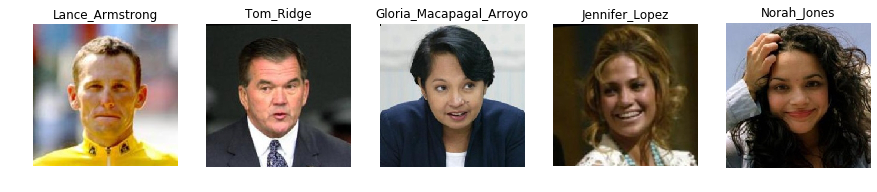

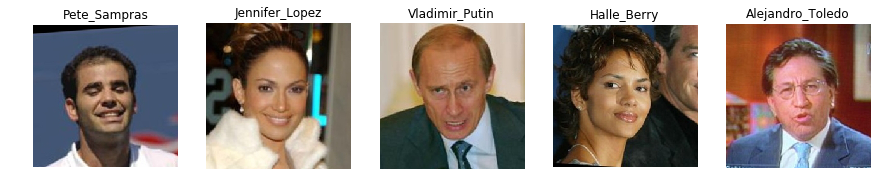

In [6]:
visualize(x_train, y_train)
visualize(x_test, y_test)

Let us now read the video classification data, as well. You have to implement function to load video data.

Function $\tt{load}$\_$\tt{video}$\_$\tt{data}$ should also return a tuple of 4 dictionaries: the first two are training images and labels, the second two are testing videos and labels. The training data is in the same format as in image classification task. The keys of testing data and labels are video ids and the values are the lists of frames and the strings with names, respectively.

In [7]:
def load_video_data(dir_name = face_dir.joinpath('video_classification')):
    """
    Loads the video data
    
    Parameters
    ----------
    dir_name : Path or str
        Path to the images
    
    Returns
    -------
    x_train : dict
        The training data.
        A dictionary where the keys are the image names and the 
        values are numpy arrays containing the images with the shape (width, height, 3).
        NOTE: The width and height varies
    y_train : dict
        The training labels.
        A dictionary where the keys are image names and the values are the class_is as strings.
    x_test : dict
        The test data.
        A dictionary where the keys are the video ids and the values are lists of 
        numpy arrays containing the images with the shape (width, height, 3).
        NOTE: The width and height varies
    y_test : dict
        The test labels.
        A dictionary where the keys are image names and the values are the class_ids as strings.
    """
    
    x_train = dict()
    x_test = dict()

    train_dir = Path(dir_name).joinpath('train')
    test_dir = Path(dir_name).joinpath('test')
    
    train_files = train_dir.joinpath('images').glob('*.jpg')
    for f in tqdm_notebook(train_files, desc='train'):
        # NOTE: We swap from bgr to rgb with [:,:,::-1]
        x_train[f.name] = cv2.imread(str(f), cv2.IMREAD_COLOR)[:,:,::-1]
        
    y_train = dict(pd.read_csv(train_dir.joinpath('y_train.csv')).values)
    
    # NOTE: The first directory is 'this' dir
    test_dirs = sorted(test_dir.joinpath('videos').glob('**'))[1:]
    for d in tqdm_notebook(test_dirs, desc='test_dir'):
        images = []
        image_paths = sorted(d.glob('*.jpg'))
        for f in tqdm_notebook(image_paths, desc='test_img', leave=False):
            # NOTE: We swap from bgr to rgb with [:,:,::-1]
            images.append(cv2.imread(str(f), cv2.IMREAD_COLOR)[:,:,::-1])
        
        x_test[d.name] = images
        
    y_test = dict(pd.read_csv(test_dir.joinpath('y_test.csv')).values.astype(str))
    
    return x_train, y_train, x_test, y_test

In [8]:
video_train, train_labels, video_test, test_labels = load_video_data()
print(f'{len(video_train)} \ttraining images')
print(f'{len(video_test)} \ttesting videos')


729 	training images
70 	testing videos


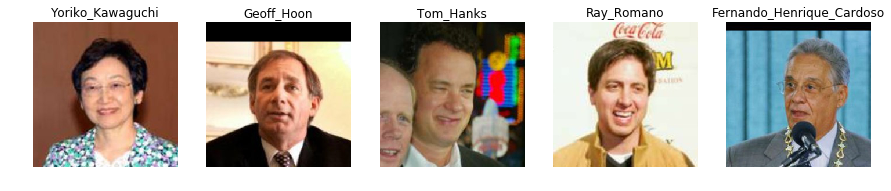

In [9]:
visualize(video_train, train_labels)

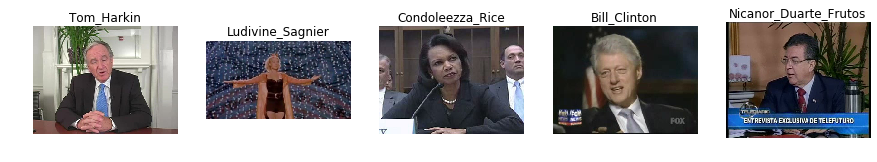

In [10]:
visualize({i:video_test[i][1] for i in video_test}, test_labels)

### Preprocessing (3 points)
You have to implement preprocessing function in the cell below.
Getting a list of images as an input the this function should detect the face on each image, find the facial keypoints () and then crop and normalize the image according to these keypoints. The output of this function is the list of images which contain only the aligned face and should be converted to the tensor of the shape $(N, 224, 224, 3)\ $ where $N$ is the length of the initial list. You can add extra arguments to the preprocess function if necessary (i.e. flag $\tt{is}$\_$\tt{video}$ to determine if the list of images is video sequence or not).

For face detection and facial keypoint regression you can use your models from the previous tasks.

> **NOTE:** In order to ensure good quality, we use the dlib toolkit to get the facial landmarks. See http://dlib.net/face_landmark_detection.py.html and https://www.pyimagesearch.com/2017/04/03/facial-landmarks-dlib-opencv-python/ for details

In [11]:
url = 'http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2'
landmark_file = Path('.').joinpath('shape_predictor_68_face_landmarks.dat')
landmark_compressed_file = Path('.').joinpath('shape_predictor_68_face_landmarks.dat.bz2')

In [12]:
if not landmark_compressed_file.is_file():
    print(f'Downloading {landmark_compressed_file}')
    response = requests.get(url)
    with landmark_compressed_file.open('wb') as f:
        f.write(response.content)
else:
    print(f'{landmark_compressed_file} found') 

shape_predictor_68_face_landmarks.dat.bz2 found


In [13]:
if not landmark_file.is_file():
    print(f'Decompressing {landmark_compressed_file}')
    with landmark_compressed_file.open('rb') as src_f, landmark_file.open('wb') as dst_f:
        dst_f.write(bz2.decompress(src_f.read()))
else:
    print(f'{landmark_file} found')

shape_predictor_68_face_landmarks.dat found


In [14]:
def landmarks_to_np(landmarks):
    """
    Convert landmarks to a numpy array
    
    Parameters
    ----------
    landmarks : dlib.full_object_detection
        Detected landmarks
        
    Returns
    -------
    np_landmarks : np.array, shape (68, 2)
        The landmarks converted to numpy
        There are 68 landmarks, each with an (x, y) coordinate
        
    References
    ----------
    https://github.com/jrosebr1/imutils/blob/master/imutils/face_utils/helpers.py
    """
    
    np_landmarks = np.zeros((landmarks.num_parts, 2), dtype=int)

    for i in range(0, landmarks.num_parts):
        np_landmarks[i] = (landmarks.part(i).x, landmarks.part(i).y)

    return np_landmarks

In [15]:
def get_eyes(landmarks):
    """
    Return a tuple of the eyes
    
    Parameters
    ----------
    landmarks : np.array, shape (68, 2)
        The landmarks converted to numpy
        There are 68 landmarks, each with an (x, y) coordinate 
    
    Returns
    -------
    eyes : tuple, len (2,)
        A tuple consisting of the eyes on the form
        >>> (eye_1, eye_2)
        Both eye_1 and eye_2 are np.arrays with len 2, 
        consisting of the x-coordinate and the y-coordinate of the eye
    """

    # NOTE: The indexing of the keypoints can be found here:
    # https://www.pyimagesearch.com/wp-content/uploads/2017/04/facial_landmarks_68markup.jpg
    # NOTE: Recall that python starts counting from 0, hence off-by-one with respect to facial landmarks
    # Find the midpoints of the eyes
    left_eye_center = np.round(landmarks[[36, 37, 38, 39, 40, 41], :].mean(axis=0)).astype(int)
    right_eye_center = np.round(landmarks[[42, 43, 44, 45, 46, 47], :].mean(axis=0)).astype(int)

    eyes = (left_eye_center, right_eye_center)
    
    return eyes

In [18]:
def get_eyes_angle(eyes):
    """
    Returns the angle between a one of the eyes and a horizontal line crossing the second eye
    
    Parameters
    ----------
    eyes : tuple, len (2,)
        A tuple consisting of the eyes on the form
        >>> (eye_1, eye_2)
        Both eye_1 and eye_2 are np.arrays with len 2, 
        consisting of the x-coordinate and the y-coordinate of the eye
    
    Returns
    -------
    eyes_angle_deg : float
        The angle given in degrees
    """
    # Find the angle between the segment connecting two eyes and horizontal line
    eye_1, eye_2 = eyes
    eye_1_x_pos = eye_1[0]
    eye_2_x_pos = eye_2[0]
    
    # Identify the left and the rigth eye
    if eye_1_x_pos < eye_2_x_pos:
        left_eye = np.array(eye_1)
        right_eye = np.array(eye_2)
    else:
        left_eye = np.array(eye_2)
        right_eye = np.array(eye_1)
        
    # Construct the horizontal point
    horizontal_form_left_eye = np.array((right_eye[0], left_eye[1]))
    
    # Calculate the vectors to find the angle between
    l_to_h = horizontal_form_left_eye - left_eye
    l_to_r = right_eye - left_eye
    
    # Calculate the angle in radians
    eyes_angle_rad = \
        np.arccos(np.dot(l_to_h, l_to_r)/\
                  (np.linalg.norm(l_to_h)*np.linalg.norm(l_to_r)))
    
    # The angle will depend of which eye is on top
    # We define the positive angle between the horizontal line and the rigth eye 
    if left_eye[1] > right_eye[1]:
        eyes_angle_rad = - eyes_angle_rad
    
    # Convert to degrees
    eyes_angle_deg = eyes_angle_rad * 180/np.pi
    
    return eyes_angle_deg

In [19]:
def bounding_rectangle_to_np(rectangle):
    """
    Convert the rectangle to a numpy array
    
    Parameters
    ----------
    rectangle : rectangle
        Rectangle prediction from dlib
        
    Returns
    -------
    np_rectangle : np.array, shape (4,)
        The rectangle on the form (top, bottom, left, right)
    """
    
    np_rectangle = np.array([rectangle.top(), rectangle.bottom(), rectangle.left(), rectangle.right()])
    return np_rectangle

In [26]:
def get_crop_indices(img_shape, eyes):
    """
    Returns the cropping indices
    
    The algorithms tries to center the eyes
    
    Parameters
    ----------
    img_shape : tuple, len (3,)
        Image to be processed
    bbox : np.array, shape(4,)
        The bounding box on the form (top, bottom, left, right)
    eyes : tuple, len (2,)
        A tuple consisting of the eyes on the form
        >>> (eye_1, eye_2)
        Both eye_1 and eye_2 are np.arrays with len 2, 
        consisting of the x-coordinate and the y-coordinate of the eye
        
    Return
    ------
    crop_indices : np.array, shape (4,)
        The cropping indices on the form (top, bottom, left, right) 
    """
    
    # In order to not stretch the image, we use the largest distance from start to end to decide the crop indices
    w_max, h_max, _ = img_shape

    # Based on the findings from
    # https://upload.wikimedia.org/wikipedia/commons/0/06/AvgHeadSizes.png
    # We have that head to chin is at the 99 percentile for men is 10 cm
    # and that center of eye distance at the 99 percentile for men is 7.4 cm
    # This means that the box size should include most of the heads if we multiply the
    # center of eye distance of eyes in pixels with the head_eye_ratio
    # However, we add some pad as people are usually not in the 99 percentile
    pad = 3
    head_eye_ratio = pad+10/7.4
    eye_distance = np.linalg.norm(eyes[0] - eyes[1])
    box_size = np.floor(eye_distance*head_eye_ratio).astype(int)
    half_size = (box_size/2).astype(int)

    # Find the center of the eyes
    x_center, y_center = np.round(np.vstack(eyes).mean(axis=0)).astype(int)
    
    new_top = y_center - half_size
    new_bottom = y_center + half_size
    new_left = x_center - half_size
    new_right = x_center + half_size
    
    # Deal with corner cases
    # NOTE: This list of corner cases is not exhaustive
    y_shift = 0
    x_shift = 0
    
    if new_top < 0:
        y_shift = -new_top
    if new_bottom > h_max:
        y_shift = h_max - new_bottom
    if new_left < 0:
        x_shift = -new_left
    if new_right > w_max:
        x_shift = w_max - new_right
            
    new_top = (new_top + y_shift).clip(0, h_max)
    new_bottom = (new_bottom + y_shift).clip(0, h_max)
    new_left = (new_left + x_shift).clip(0, w_max)
    new_right = (new_right + x_shift).clip(0, w_max)
       
    crop_indices = np.array([new_top, new_bottom, new_left, new_right])
    
    return crop_indices

In [27]:
def get_index_with_largest_box(bounding_rectangles):
    """
    Returns the index for the box with the largest area
    
    Parameters
    ----------
    bounding_rectangles : list
        List of rectangle prediction from dlib
        
    Returns
    -------
    index_max_area : int
        The index with the highest area
    """
    
    index_max_area = 0
    max_area = 0
    for index, rectangle in enumerate(bounding_rectangles):
        top, bottom, left, right = bounding_rectangle_to_np(rectangle)
        area = (bottom-top)*(right-left)
        if area > max_area:
            max_area = area
            index_max_area = index
    
    return index_max_area

In [28]:
def get_rot_eyes(eyes, rot_mat):
    """
    Rotates the eyes accoring to the rotation matrix
    
    Parameters
    ----------
    eyes : tuple, len (2,)
        A tuple consisting of the eyes on the form
        >>> (eye_1, eye_2)
        Both eye_1 and eye_2 are np.arrays with len 2, 
        consisting of the x-coordinate and the y-coordinate of the eye
    rot_mat : np.array, shape (2, 3)
        The rotation matrix
        
    Returns
    -------
    rot_eyes : tuple, len (2,)
        The rotated eyes on the same format as the input `eyes`
    """
    
    # Rotate the eyes
    stacked_eyes = np.vstack((eyes[0], eyes[1]))
    eyes_w_ones = np.hstack((stacked_eyes, np.ones((stacked_eyes.shape[0], 1))))
    rot_eyes = np.round(rot_mat.dot(eyes_w_ones.T)).T.astype(int)
    
    rot_left_eye = rot_eyes[0, :]
    rot_right_eye = rot_eyes[1, :]
    rot_eyes = (rot_left_eye, rot_right_eye)
    
    return rot_eyes

In [29]:
def crop_and_resize(img, crop_indices, size=224):
    """
    Cropping and resizing the image
    
    Parameters
    ----------
    img : np.array, shape (width, height, 3)
        Image to be processed
    crop_indices : np.array, shape (4,)
        The rectangle on the form (top, bottom, left, right)
    size : int
        The width and heigth of the output image
        
    Returns
    -------
    processed_img : np.array, shape (*size, 3)
        The cropped and resized image
    """
    
    top, bottom, left, right = crop_indices
    cropped_img = img[top:bottom, left:right]
    processed_img = resize(cropped_img, (size, size), mode='reflect', anti_aliasing=True)
    
    return processed_img

In [30]:
def preprocess_imgs(imgs, verbose=False):
    """
    Preprocesses images by aligning and resize faces
    
    Notes
    -----
    If the face detection algorithm fails, no preprocessing will be done
    
    Parameters
    ----------
    imgs : list, shape (n, )
        A list of images as numpy arrays on with the shape (width, height, 3)
        NOTE: The shapes of the images varies
    verbose : bool
        Whether or not to prin warnings
    
    Returns
    -------
    processed_imgs : np.arrsy, shape (m, 224, 224, 3)
        The preprocessed images containing the resized, aligned faces
    """
    
    # HOG based face detector
    face_detector = dlib.get_frontal_face_detector()
    
    landmark_predictor = dlib.shape_predictor(str(landmark_file))
    
    processed_imgs = []
    for img in tqdm_notebook(imgs, desc='preprocessing', leave=False):
        # Detect the faces, we know apriori that there is one person per image
        # NOTE: The 1 in the second argument indicates that we should upsample the image 1 time. 
        #       This will make everything bigger and allow us to detect more faces.
        bounding_rectangles = face_detector(img, 1)
        
        if len(bounding_rectangles) != 0:
            index = 0
            if len(bounding_rectangles) > 1:
                if verbose:
                    print('Warning: Several faces found, choosing the largest')
                index = get_index_with_largest_box(bounding_rectangles)
                
            bounding_rectangle = bounding_rectangles[index]
            landmarks = landmark_predictor(img, bounding_rectangle)
            
            # Cast to numpy
            bounding_rectangle = bounding_rectangle_to_np(bounding_rectangle)
            landmarks = landmarks_to_np(landmarks)
            
            eyes = get_eyes(landmarks)
            eyes_angle_deg = get_eyes_angle(eyes)
        
            # Rotate the image
            image_center = tuple((np.array(img.shape[1::-1]) / 2).astype(int))
            rot_mat = cv2.getRotationMatrix2D(image_center, eyes_angle_deg, 1.0)
            rot_img = cv2.warpAffine(img, rot_mat, img.shape[1::-1], flags=cv2.INTER_LINEAR)

            rot_eyes = get_rot_eyes(eyes, rot_mat) 
            
            crop_indices = get_crop_indices(img.shape, rot_eyes)
            
        else:
            if verbose:
                print('Warning: No face found, only cropping will be done')
            w, h, _ = img.shape
            size = w if w < h else h
            rot_img = img
            crop_indices = np.array([0, size, 0, size])
        
        # Crop the and rescale image
        processed_img = crop_and_resize(rot_img, crop_indices)
        processed_imgs.append(processed_img)
        
    processed_imgs = np.array(processed_imgs)
    
    return processed_imgs

#### Visualization of preprocessing

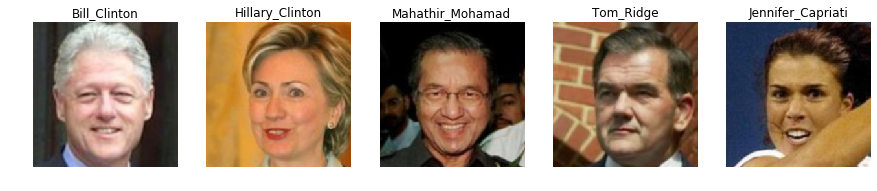

In [31]:
visualize(x_train, y_train, function = lambda x:preprocess_imgs(x)[0])

The neural network is already trained on the other face dataset. You should use this network as feature extractor to get descriptors of the faces. You can choose any hidden layer you need (or several layers) to extract features and any classification method.

In [32]:
model = load_model('face_recognition_model.h5')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 112, 112, 64)      0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 112, 112, 128)     147584    
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 56, 56, 128)       0         
_________________________________________________________________
conv3_1 (Conv2D)             (None, 56, 56, 256)       295168    
__________

Here is an example of using the network as feature extractor. The shape of input tensor has to be (n_images, 224, 224, 3), so you can input several images simultaneously and get their face descriptors of shape (n_images, n_components).

In [33]:
def get_layer_output(images, layer = 'fc6'):
    assert len(images.shape)==4, 'Wrong input dimentionality!'
    assert images.shape[1:]==(224,224,3), 'Wrong input shape!'
    
    network_output = model.get_layer(layer).output
    feature_extraction_model = Model(model.input, network_output)
    
    output = feature_extraction_model.predict(images)
    return output

In [34]:
img = cv2.resize(x_train['0.jpg'], (224,224)).reshape(1,224,224,3)
out = get_layer_output(img)
print(out.shape)

(1, 4096)


### Training classifier (2 points)


You have to implement class $\tt{Classifier}$ with methods $\tt{fit}$, $\tt{classify}$\_$\tt{images}$ and $\tt{classify}$\_$\tt{videos}$ in the cell below. 
The method $\tt{Classifier.fit}$ gets two dictionaries as input: train images and labels, and trains the classifier to predict the person shown on the image.
$\tt{Classifier.classify}$\_$\tt{images}$ gets the dictionary of test images (with filenames as keys) as input and should return the dictionary of the predicted labels.
$\tt{Classifier.classify}$\_$\tt{videos}$ is similar to the previous one, but gets the dictionary of test videos (with video as keys) as input.

To classify video you can combine the predictions for its frames any way you want (averaging, voting, etc.).
If video classification takes too long you can use face detector not in all the frames but every few frames while preprocessing video frames. 
Besides, sometimes the face is hardly detected on the image and the frame in which the detector works wrong can add noise to the prediction. Hence, the result of the prediction without using such frames may be better.

In [35]:
class Classifier():
    "Class for classifying a person based on features from a pretrained network and nearest neighbors"
    
    def __init__(self, nn_model, layer='fc7', neighbors=1, weights='uniform'):
        """
        Constructor for the classifier
        
        Parameters
        -----------
        nn_model : Sequential
            The neural network to use
        layer : str
            Name of an existing layer in the model
        neighbors : int
            Number of neighbors to use in the kNN classifier
        weights : str
            The weights of the kNN classifier
        """        
        network_output = nn_model.get_layer(layer).output
        self.feature_extractor = Model(model.input, network_output)
        self.kNN = kNN(n_neighbors=neighbors, weights=weights)

    def fit(self, train_imgs, train_labels):
        """
        Fits the classifier
        
        Parameters
        ----------
        train_imgs : dict
            The training data.
            A dictionary where the keys are the image names and the 
            values are numpy arrays containing the images with the shape (width, height, 3).
            NOTE: The width and height varies
        train_labels : dict
            The training labels.
            A dictionary where the keys are image names and the values are the class_is as strings.
        """
        
        # Make the data and the labels aligned
        imgs = []
        y = []
        
        names = train_imgs.keys()
        for name in names:
            imgs.append(train_imgs[name])
            y.append(train_labels[name])
        
        print('Preprocessing...')
        imgs = preprocess_imgs(imgs)
        print('done')
        print('Extracting features...', end='')
        x = self.feature_extractor.predict(imgs, verbose=1)
        print('done')
        print('Fitting...', end='', flush=True)
        self.kNN.fit(x, y)
        print('done')

    def classify_images(self, test_imgs):
        """
        Makes a prediction for the test images
        
        Parameters
        ----------
        test_imgs : dict
            The test data.
            A dictionary where the keys are the image names and the 
            values are numpy arrays containing the images with the shape (width, height, 3).
            NOTE: The width and height varies
            
        Returns
        -------
        predicted : dict
            The prediction for the input images.
            A dictionary where the keys are the image names and the values are predicted labels
        """
        
        names = test_imgs.keys()
        imgs = test_imgs.values()
        print('Preprocessing...')
        imgs = preprocess_imgs(imgs)
        print('done')
        print('Extracting features...')
        x = self.feature_extractor.predict(imgs, verbose=1)
        print('done')
        print('Predicting...', end='', flush=True)
        pred = self.kNN.predict(x)
        print('done')
        
        predicted = {n: p for n, p in zip(names, pred)}
        
        return predicted
   
    def classify_videos(self, test_video):
        """
        Makes a prediction for the videos
        
        The prediciton will be the most common prediction in the frames
        
        Parameters
        ----------
        test_video : dict
            The test data.
            A dictionary where the keys are the video ids and the values are lists of 
            numpy arrays containing the images with the shape (width, height, 3).
            NOTE: The width and height varies
        
        Returns
        -------
        predicted : dict
            The prediction for the input images.
            A dictionary where the keys are the video ids and the values are predicted labels
        """
        
        names = test_video.keys()
        videos = test_video.values()
        preds = []
        for video in tqdm_notebook(videos, desc='videos'):
            imgs = preprocess_imgs(video)
            x = self.feature_extractor.predict(imgs, verbose=1)
            video_preds = self.kNN.predict(x)
            preds.append(Counter(video_preds).most_common(n=1)[0][0])
        
        predicted = {n: p for n, p in zip(names, preds)}
        
        return predicted

Now we can build the classifier, fit it and use to predict the labels of testing images.

In [36]:
img_classifier = Classifier(model)

In [37]:
img_classifier.fit(x_train, y_train)

Preprocessing...


done
661/661 [==============================] - 2s 3ms/step
done
Fitting...done


In [38]:
y_out = img_classifier.classify_images(x_test)

Preprocessing...


done
Extracting features...
808/808 [==============================] - 2s 3ms/step
done
Predicting...done


### Image classification quality (2 points)

Let us check the accuracy of your classification. To obtain 1 point for that rubric your implementation must have accuracy at least 0.90, to obtain 2 points — at least 0.95.

In [39]:
def check_test(output, gt):    
    correct = 0.
    total = len(gt)
    for k, v in gt.items():
        if output[k] == v:
            correct += 1
    accuracy = correct / total

    return f'Classification accuracy is {accuracy:.4f}'

In [40]:
print(check_test(y_out, y_test))

Classification accuracy is 0.9653


### Video classification quality (2 points)

Let us check the quality of video classification. To obtain 1 point for that rubric your implementation must have accuracy at least 0.80, to obtain 2 points — at least 0.85.

In [41]:
video_classifier = Classifier(model)

In [42]:
video_classifier.fit(video_train, train_labels)

Preprocessing...


done
729/729 [==============================] - 3s 4ms/step
done
Fitting...done


In [43]:
y_video_out = video_classifier.classify_videos(video_test)

125/125 [==============================] - 1s 8ms/step


125/125 [==============================] - 0s 3ms/step


125/125 [==============================] - 0s 3ms/step


125/125 [==============================] - 0s 3ms/step


125/125 [==============================] - 0s 3ms/step


125/125 [==============================] - 0s 3ms/step


125/125 [==============================] - 0s 3ms/step


125/125 [==============================] - 0s 3ms/step


125/125 [==============================] - 0s 3ms/step


121/121 [==============================] - 0s 3ms/step


125/125 [==============================] - 0s 3ms/step


125/125 [==============================] - 0s 3ms/step


125/125 [==============================] - 0s 3ms/step


121/121 [==============================] - 0s 3ms/step


125/125 [==============================] - 0s 3ms/step


125/125 [==============================] - 0s 3ms/step


125/125 [==============================] - 0s 3ms/step


125/125 [==============================] - 0s 3ms/step


125/125 [==============================] - 0s 3ms/step


125/125 [==============================] - 0s 3ms/step


125/125 [==============================] - 0s 3ms/step


125/125 [==============================] - 0s 3ms/step


123/123 [==============================] - 1s 8ms/step


125/125 [==============================] - 0s 3ms/step


125/125 [==============================] - 0s 3ms/step


125/125 [==============================] - 0s 3ms/step


125/125 [==============================] - 0s 3ms/step


117/117 [==============================] - 0s 3ms/step


125/125 [==============================] - 0s 3ms/step


125/125 [==============================] - 0s 3ms/step


125/125 [==============================] - 0s 3ms/step


125/125 [==============================] - 0s 3ms/step


125/125 [==============================] - 0s 3ms/step


125/125 [==============================] - 0s 3ms/step


125/125 [==============================] - 0s 3ms/step


125/125 [==============================] - 0s 3ms/step


125/125 [==============================] - 0s 3ms/step


125/125 [==============================] - 0s 3ms/step


125/125 [==============================] - 0s 3ms/step


119/119 [==============================] - 1s 8ms/step


117/117 [==============================] - 0s 3ms/step


125/125 [==============================] - 0s 3ms/step


125/125 [==============================] - 0s 3ms/step


125/125 [==============================] - 0s 3ms/step


125/125 [==============================] - 0s 3ms/step


125/125 [==============================] - 0s 3ms/step


125/125 [==============================] - 0s 3ms/step


125/125 [==============================] - 0s 3ms/step


125/125 [==============================] - 0s 3ms/step


125/125 [==============================] - 0s 3ms/step


125/125 [==============================] - 0s 3ms/step


125/125 [==============================] - 0s 3ms/step


125/125 [==============================] - 0s 3ms/step


125/125 [==============================] - 0s 3ms/step


125/125 [==============================] - 0s 3ms/step


125/125 [==============================] - 0s 3ms/step


125/125 [==============================] - 0s 3ms/step


125/125 [==============================] - 0s 3ms/step


125/125 [==============================] - 0s 3ms/step


115/115 [==============================] - 1s 7ms/step


125/125 [==============================] - 0s 3ms/step


125/125 [==============================] - 0s 3ms/step


125/125 [==============================] - 0s 3ms/step


125/125 [==============================] - 0s 3ms/step


125/125 [==============================] - 0s 3ms/step


125/125 [==============================] - 0s 3ms/step


125/125 [==============================] - 0s 3ms/step


125/125 [==============================] - 0s 3ms/step


125/125 [==============================] - 0s 3ms/step


125/125 [==============================] - 0s 3ms/step



In [44]:
print(check_test(y_video_out, test_labels))

Classification accuracy is 0.6286
